# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

0
1
2
3
4
5


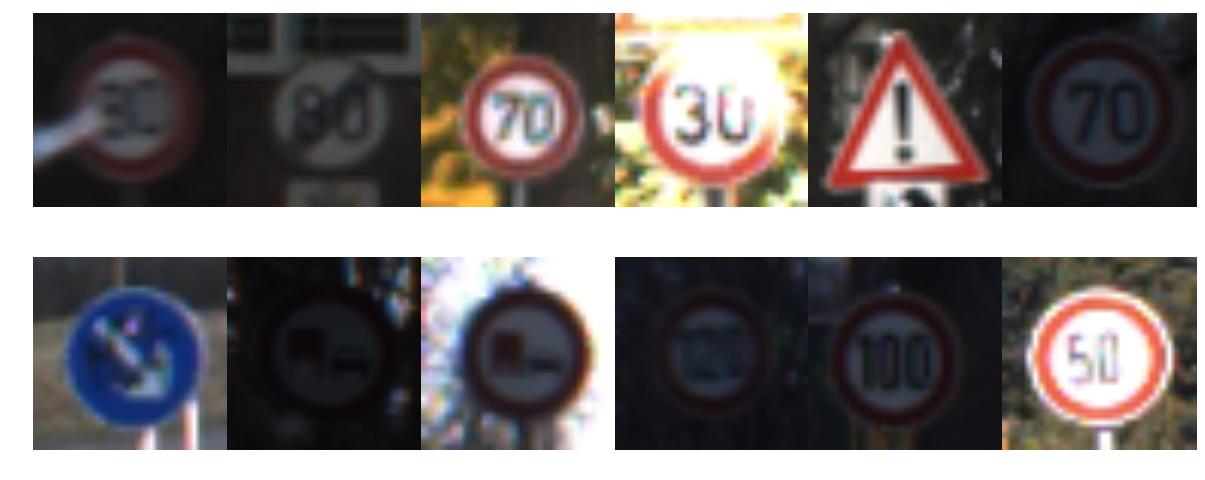

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
# Visualizations will be shown in the notebook.
%matplotlib inline

def show_some_images(train_input):
    n_rows = 2
    n_cols = 6
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6))
    fig.subplots_adjust(hspace=.1, wspace=.001)
    axs = axs.ravel()
    for i in range(n_cols):
        print(i)
        index = random.randint(0, len(train_input))
        image = train_input[index].squeeze()
        axs[i].axis('off')
        axs[i].imshow(image)
        index = random.randint(0, len(train_input))
        image = train_input[index].squeeze()
        axs[i+n_cols].axis('off')
        axs[i+n_cols].imshow(image)
    plt.show()

show_some_images(X_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

0
1
2
3
4
5


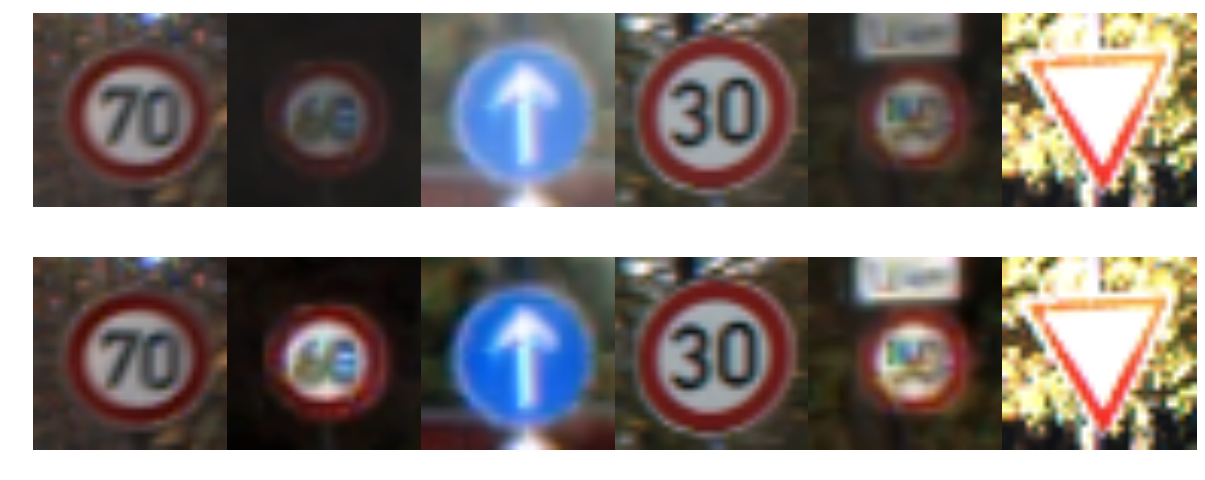

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
# Visualizations will be shown in the notebook.
%matplotlib inline

def _ycc(r, g, b): # in (0,255) range
    y = .299*r + .587*g + .114*b
    cb = 128 -.168736*r -.331364*g + .5*b
    cr = 128 +.5*r - .418688*g - .081312*b
    return y, cb, cr

def _rgb(y, cb, cr):
    r = y + 1.402 * (cr-128)
    g = y - .34414 * (cb-128) -  .71414 * (cr-128)
    b = y + 1.772 * (cb-128)
    return r, g, b

def RGB2YUV2(img_in):
    img_out = img_in
    img_out[:,:,0] = .299*img_in[:,:,0] + .587*img_in[:,:,1] + .114*img_in[:,:,2]
    img_out[:,:,1] = 128 -.168736*img_in[:,:,0] -.331364*img_in[:,:,1] + .5*img_in[:,:,2]
    img_out[:,:,2] = 128 +.5*img_in[:,:,0] - .418688*img_in[:,:,1] - .081312*img_in[:,:,2]
    return img_out

def YUV2RGB2(img_in):
    img_out = img_in
    img_out[:,:,0] = img_in[:,:,0] + 1.402 * (img_in[:,:,2]-128)
    img_out[:,:,1] = img_in[:,:,0] - .34414 * (img_in[:,:,1]-128) -  .71414 * (img_in[:,:,2]-128)
    img_out[:,:,2] = img_in[:,:,0] + 1.772 * (img_in[:,:,2]-128)
    return img_out

def RGB2YUV(img_in):
    return cv2.cvtColor(img_in, cv2.COLOR_BGR2YUV, 3)

def YUV2RGB(img_in):
    return cv2.cvtColor(img_in, cv2.COLOR_YUV2RGB, 3)

def grayscaleImage(img_in):
    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    return gray

def LocalConstrastNormalization(img):
    #clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    #img_clahe = clahe.apply(img)
    #return img_clahe
    selem = disk(5)
    img_eq = rank.equalize(img, selem=selem)
    return img_eq

def GlobalConstrastNormalize(img_in):
    return exposure.equalize_hist(img_in)

def preprocess_image(img_in):
    #yuv_img = RGB2YUV2(img_in)
    # global_constrast_img = yuv_img
    # global_constrast_img[:,:,0] = GlobalConstrastNormalize(global_constrast_img)[:,:,0]
    # local_constrast_img = yuv_img
    # local_constrast_img[:,:,0] = GlobalConstrastNormalize(local_constrast_img)[:,:,0]
    grayscale_img = grayscaleImage(img_in)
    zeros = np.zeros((32,32,3))
    norm_image = cv2.normalize(img_in, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image

def preprocess_image_test(train_input):
    n_rows = 2
    n_cols = 6
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6))
    fig.subplots_adjust(hspace=.1, wspace=.001)
    axs = axs.ravel()
    for i in range(n_cols):
        print(i)
        index = random.randint(0, len(train_input))
        image = train_input[index].squeeze()
        axs[i].axis('off')
        axs[i].imshow(image)
        new_img = preprocess_image(image)
        axs[i+n_cols].axis('off')
        axs[i+n_cols].imshow(new_img, cmap="Greys_r")
    plt.show()


def preprocess_images(train_input):
    new_train_input = []
    for index in range(len(train_input)):
        new_train_input.append(preprocess_image(train_input[index]))
        # plt.imshow(new_train_input[index])
        # plt.show()
        #if (index%20 == 0):
        #    print(index)
    return new_train_input

def preprocess_images_test(train_input):
    train_input = preprocess_images(train_input)
    for i in range(10):
        index = random.randint(0, len(train_input))
        image = train_input[index].squeeze()
        plt.figure(figsize=(1,1))
        plt.imshow(image, cmap="Greys_r")
        plt.show()

#preprocess_images_test(X_train)

X_train_normalized = preprocess_images(X_train)
X_test_normalized = preprocess_images(X_test)

preprocess_image_test(X_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
A lot of techniques came into my mind, grayscaling the images, normalizing the images locally and globally, etc. And according to LeCun's paper, they also tried converting the RGB images to YUV images. I tried replicating their steps but the resultant accuracy is too low. After tryin several combinations, only localizing the contrast of the images gives the best result, which is what I eventually did.

In [5]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train_normalized,X_validation,y_train,y_validation = train_test_split(X_train_normalized,y_train,test_size=0.4,random_state=0)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I shuffled the data and I split the training data for cross-validation.

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# The model
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)) # (height, width, input_depth, output_depth)
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b # (batch, height, width, depth)

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I'm using the **The LeNet architecture** that accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.<br />
**Architecture**<br />
**Layer 1:** Convolutional. The output shape should be 28x28x6.<br />
**Activation.** RELU<br />
**Pooling.** The output shape should be 14x14x6.<br />
**Layer 2:** Convolutional. The output shape should be 10x10x16.<br />
**Activation.** RELU<br />
**Pooling.** The output shape should be 5x5x16.<br />
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.<br />
**Layer 3:** Fully Connected. This should have 120 outputs.<br />
**Activation.** Your choice of activation function.<br />
**Layer 4:** Fully Connected. This should have 84 outputs.<br />
**Activation.** Your choice of activation function.<br />
**Layer 5:** Fully Connected (Logits). This should have 43 outputs.<br />

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)



#Create a training pipeline that uses the model to classify data.
rate = 0.001
EPOCHS=20
BATCH_SIZE=128
save_file = './model.ckpt'

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
test_prediction = tf.argmax(logits, 1)
test_softmax = tf.nn.softmax(logits)


#Evaluate how well the loss and accuracy of the model for a given dataset.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#Run the training data through the training pipeline to train the model.
#Before each epoch, shuffle the training set.
#After each epoch, measure the loss and accuracy of the validation set.
#Save the model after training.
with tf.Session() as sess:
    print('Session starts')
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_file)
    print("Model saved")

# Do evaluation
with tf.Session() as sess:
    #saver = tf.train.import_meta_graph('model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test)

    prediction=test_accuracy * len(X_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Session starts
Training...

EPOCH 1 ...
Validation Accuracy = 0.778

EPOCH 2 ...
Validation Accuracy = 0.882

EPOCH 3 ...
Validation Accuracy = 0.920

EPOCH 4 ...
Validation Accuracy = 0.931

EPOCH 5 ...
Validation Accuracy = 0.940

EPOCH 6 ...
Validation Accuracy = 0.956

EPOCH 7 ...
Validation Accuracy = 0.959

EPOCH 8 ...
Validation Accuracy = 0.958

EPOCH 9 ...
Validation Accuracy = 0.961

EPOCH 10 ...
Validation Accuracy = 0.973

EPOCH 11 ...
Validation Accuracy = 0.973

EPOCH 12 ...
Validation Accuracy = 0.974

EPOCH 13 ...
Validation Accuracy = 0.976

EPOCH 14 ...
Validation Accuracy = 0.973

EPOCH 15 ...
Validation Accuracy = 0.979

EPOCH 16 ...
Validation Accuracy = 0.980

EPOCH 17 ...
Validation Accuracy = 0.967

EPOCH 18 ...
Validation Accuracy = 0.976

EPOCH 19 ...
Validation Accuracy = 0.980

EPOCH 20 ...
Validation Accuracy = 0.964

Model saved
Test Accuracy = 0.888


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**<br/>
**optimizer:** AdamOptimizer<br/>
**batch size:** 128<br/>
**epochs:** 20<br/>

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I just chose LeNet as base architecture and tweaked the parameters a little bit.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

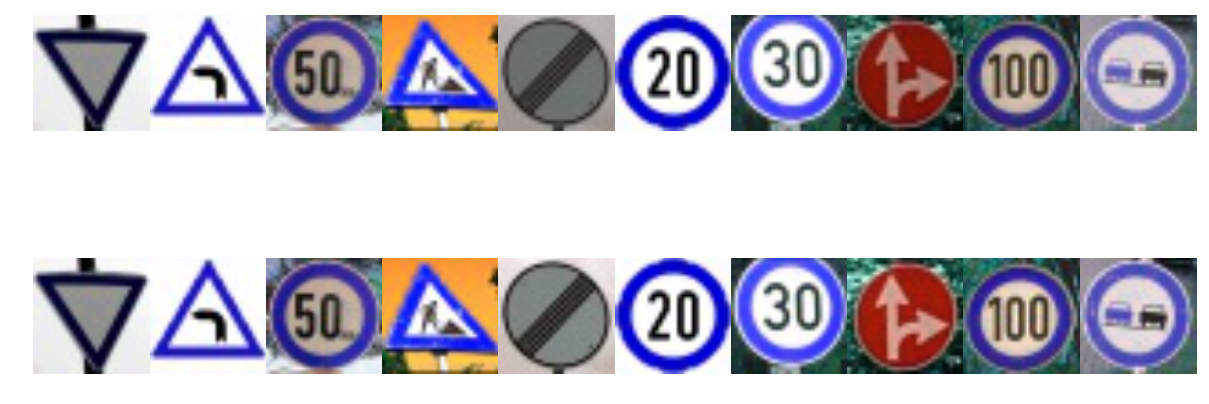

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2

new_images = []

n_rows = 2
n_cols = 10
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6))
fig.subplots_adjust(hspace=.1, wspace=.001)
axs = axs.ravel()

for i in range(n_cols):
    file_name = os.path.join(os.path.abspath('.'), 'test_images', str(i+1) + '.jpg')
    image = cv2.imread(file_name)
    axs[i].axis('off')
    axs[i].imshow(image)
    new_img = preprocess_image(image)
    axs[i+n_cols].axis('off')
    axs[i+n_cols].imshow(new_img)
    new_images.append(new_img)
    new_images.append(preprocess_image(image))
plt.show()



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** They're just a bunch of images I found on Google.

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
new_images = []

for i in range(10):
    file_name = os.path.join(os.path.abspath('.'), 'test_images', str(i+1) + '.jpg')
    image = cv2.imread(file_name)
    new_images.append(preprocess_image(image))

new_labels = [13, 19, 2, 25, 32, 0, 1, 7, 17, 18]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_accuracy = evaluate(new_images, new_labels)
    print("Test Set Accuracy = {:.3f}".format(new_accuracy))

Test Set Accuracy = 0.600


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The accuracy is 60%.

In [13]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
prediction = tf.nn.softmax(logits)
top_k = tf.nn.top_k(prediction, k=3)
new_images_pred = np.asarray(new_images)
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_prediction= sess.run(prediction, feed_dict={x: new_images_pred})
    new_top_k = sess.run(top_k, feed_dict={x: new_images_pred})

print(new_prediction)
print(new_top_k)

[[  8.69499195e-36   6.63880915e-23   5.44120348e-30   1.66445637e-30
    5.77214100e-32   4.03786917e-31   5.01718750e-37   5.75347437e-33
    9.06860752e-30   3.70087912e-16   1.11550316e-24   9.08807299e-37
    4.82192405e-16   1.00000000e+00   6.39494382e-21   4.07860128e-15
    0.00000000e+00   2.31459008e-24   3.73427225e-33   3.59319215e-38
    1.47420374e-24   1.86065049e-37   1.35454107e-23   1.47618149e-28
    4.75440399e-36   2.67564203e-20   3.48722968e-22   0.00000000e+00
    1.34691452e-24   7.54769542e-26   2.83067827e-29   3.17031355e-32
    2.39576961e-27   6.90274648e-22   7.04635252e-24   9.99199889e-11
    3.31163114e-23   8.01222448e-27   1.88215909e-15   5.18020748e-28
    2.60160529e-27   4.20297233e-28   2.88954694e-38]
 [  0.00000000e+00   1.04013374e-20   1.72829768e-05   3.19627604e-38
    1.22637018e-23   8.24202895e-02   1.21717412e-24   7.46849943e-11
    4.07554397e-33   2.24667707e-21   3.93720112e-10   1.55655118e-06
    7.42690318e-08   7.92728337e-33 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

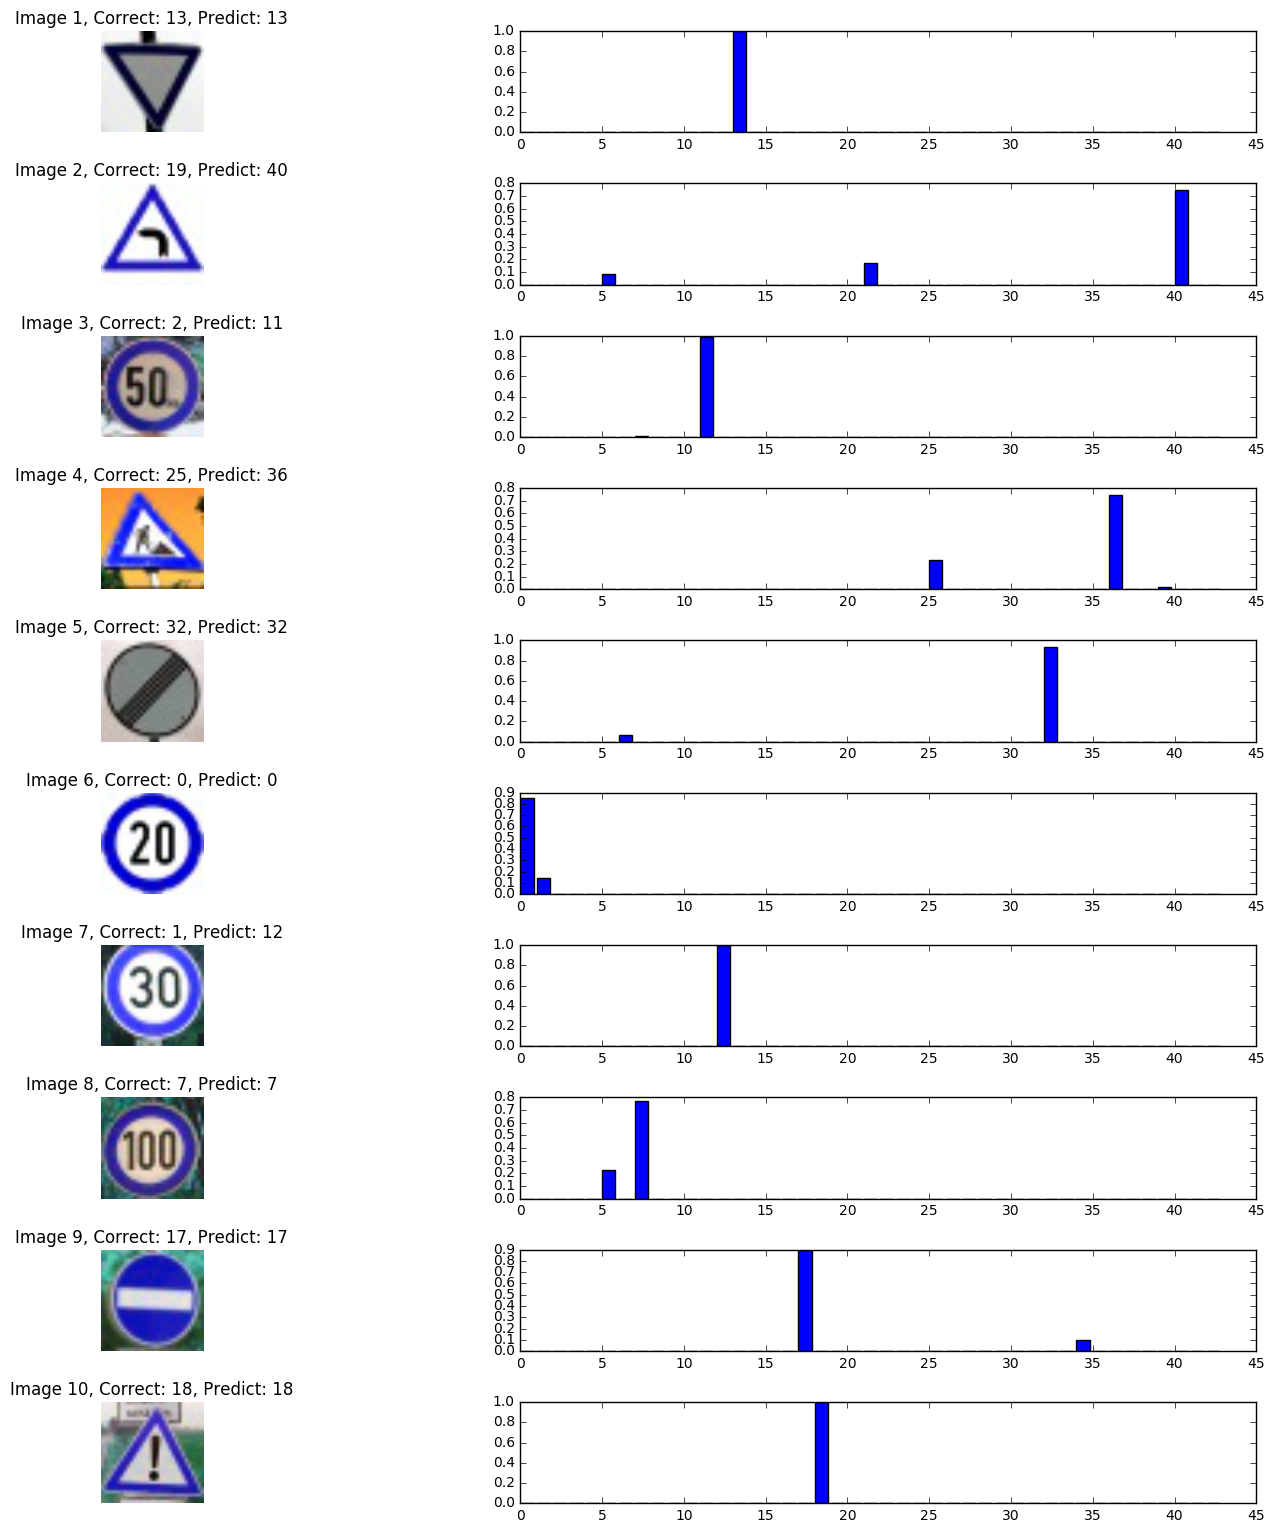

In [14]:
fig, axs = plt.subplots(10,2, figsize=(19, 19))
axs = axs.ravel()
fig.subplots_adjust(hspace=.5, wspace=.001)

count = 0
for i in range(len(new_prediction)):
    axs[count].axis('off')
    axs[count].imshow(new_images[i])
    axs[count].set_title('Image ' + str(i+1) + ', Correct: ' + str(new_labels[i]) + ', Predict: ' + str(new_top_k[1][i][0]))
    count += 1
    axs[count].bar(np.arange(n_classes), new_prediction[i])
    count += 1

**Answer:**<br/>
Four of the imaged are predicted incorrectly. All of them have their guesses pretty off except image 4, which has an about 20% chance of guessing correctly, but this is the farthest the CNN can go. For the othe six correctly-guessed images, the chance is quite. I guess I may overfit a little, pretty much starting at the fourth and fifth epoch, the accuracy has already been over 90%. Another thing to think about is all the training data are from Germany, so the CNN didn't consider the case where traffic signs are from different countries, which leads to poor performances on some of the images here.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.